# Modeling

In [1]:
!pip install xgboost

In [2]:
!pip install catboost

In [3]:
!pip install lightgbm

In [4]:
conda install lightgbm

Retrieving notices: ...working... done
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [5]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [6]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(96397, 22)
CPU times: user 147 ms, sys: 23.3 ms, total: 170 ms
Wall time: 183 ms


,card_zip_total_14,card_zip3_max_30,Merchnum_total_3,Merchnum_med_3,zip3_actual/max_14,Merchnum_desc_total_1,merch_zip_med_7,merch_zip_variability_med_30,Merchnum_med_0,Merchnum_desc_med_0,...,Merchnum_desc_med_3,Merchnum_variability_med_30,card_merch_med_60,card_zip3_med_60,merch_zip_med_0,Card_Merchnum_desc_med_60,amount_cat,card_zip_total_60,Recnum,Fraud
0,3.62,3.62,3.62,3.62,1.0,3.62,3.62,0.0,3.62,3.62,...,3.62,0.0,3.62,3.62,3.62,3.62,1,3.62,1,0
1,31.42,31.42,31.42,31.42,1.0,31.42,31.42,0.0,31.42,31.42,...,31.42,0.0,31.42,31.42,31.42,31.42,2,31.42,2,0
2,178.49,178.49,178.49,178.49,1.0,178.49,178.49,0.0,178.49,178.49,...,178.49,0.0,178.49,178.49,178.49,178.49,3,178.49,3,0
3,3.62,3.62,7.24,3.62,1.0,3.62,3.62,0.0,3.62,3.62,...,3.62,0.0,3.62,3.62,3.62,3.62,1,3.62,4,0
4,7.24,3.62,10.86,3.62,1.0,7.24,3.62,0.0,3.62,3.62,...,3.62,0.0,3.62,3.62,3.62,3.62,1,7.24,5,0


In [7]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 20

vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'card_zip_total_14',
 'card_zip3_max_30',
 'Merchnum_total_3',
 'Merchnum_med_3',
 'zip3_actual/max_14',
 'Merchnum_desc_total_1',
 'merch_zip_med_7',
 'merch_zip_variability_med_30',
 'Merchnum_med_0',
 'Merchnum_desc_med_0',
 'Merchnum_desc_med_1',
 'merch_zip_med_3',
 'Merchnum_desc_med_3',
 'Merchnum_variability_med_30',
 'card_merch_med_60',
 'card_zip3_med_60',
 'merch_zip_med_0',
 'Card_Merchnum_desc_med_60',
 'amount_cat',
 'card_zip_total_60']

In [8]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,card_zip_total_14,card_zip3_max_30,Merchnum_total_3,Merchnum_med_3,zip3_actual/max_14,Merchnum_desc_total_1,merch_zip_med_7,merch_zip_variability_med_30,...,Merchnum_desc_med_1,merch_zip_med_3,Merchnum_desc_med_3,Merchnum_variability_med_30,card_merch_med_60,card_zip3_med_60,merch_zip_med_0,Card_Merchnum_desc_med_60,amount_cat,card_zip_total_60
0,1,0,3.62,3.62,3.62,3.62,1.0,3.62,3.62,0.0,...,3.62,3.62,3.62,0.0,3.62,3.62,3.62,3.62,1,3.62
1,2,0,31.42,31.42,31.42,31.42,1.0,31.42,31.42,0.0,...,31.42,31.42,31.42,0.0,31.42,31.42,31.42,31.42,2,31.42
2,3,0,178.49,178.49,178.49,178.49,1.0,178.49,178.49,0.0,...,178.49,178.49,178.49,0.0,178.49,178.49,178.49,178.49,3,178.49
3,4,0,3.62,3.62,7.24,3.62,1.0,3.62,3.62,0.0,...,3.62,3.62,3.62,0.0,3.62,3.62,3.62,3.62,1,3.62
4,5,0,7.24,3.62,10.86,3.62,1.0,7.24,3.62,0.0,...,3.62,3.62,3.62,0.0,3.62,3.62,3.62,3.62,1,7.24


In [9]:
vars.shape

(96397, 22)

In [10]:
vars['Fraud'].sum()

1059

In [11]:
vars.head(10)

,Recnum,Fraud,card_zip_total_14,card_zip3_max_30,Merchnum_total_3,Merchnum_med_3,zip3_actual/max_14,Merchnum_desc_total_1,merch_zip_med_7,merch_zip_variability_med_30,...,Merchnum_desc_med_1,merch_zip_med_3,Merchnum_desc_med_3,Merchnum_variability_med_30,card_merch_med_60,card_zip3_med_60,merch_zip_med_0,Card_Merchnum_desc_med_60,amount_cat,card_zip_total_60
0,1,0,3.62,3.62,3.62,3.62,1.000000,3.62,3.62,0.00,...,3.62,3.62,3.62,0.00,3.62,3.62,3.62,3.62,1,3.62
1,2,0,31.42,31.42,31.42,31.42,1.000000,31.42,31.42,0.00,...,31.42,31.42,31.42,0.00,31.42,31.42,31.42,31.42,2,31.42
2,3,0,178.49,178.49,178.49,178.49,1.000000,178.49,178.49,0.00,...,178.49,178.49,178.49,0.00,178.49,178.49,178.49,178.49,3,178.49
3,4,0,3.62,3.62,7.24,3.62,1.000000,3.62,3.62,0.00,...,3.62,3.62,3.62,0.00,3.62,3.62,3.62,3.62,1,3.62
4,5,0,7.24,3.62,10.86,3.62,1.000000,7.24,3.62,0.00,...,3.62,3.62,3.62,0.00,3.62,3.62,3.62,3.62,1,7.24
5,6,0,3.67,3.67,14.53,3.62,1.000000,3.67,3.62,-0.05,...,3.67,3.62,3.67,-0.05,3.67,3.67,3.62,3.67,1,3.67
6,7,0,3.62,3.62,18.15,3.62,0.986376,7.24,3.62,0.00,...,3.62,3.62,3.62,0.00,3.62,3.62,3.62,3.62,1,3.62
7,8,0,230.32,230.32,230.32,230.32,1.000000,230.32,230.32,0.00,...,230.32,230.32,230.32,0.00,230.32,230.32,230.32,230.32,4,230.32
8,9,0,62.11,62.11,62.11,62.11,1.000000,62.11,62.11,0.00,...,62.11,62.11,62.11,0.00,62.11,62.11,62.11,62.11,2,62.11
9,10,0,10.86,3.62,21.77,3.62,0.986376,10.86,3.62,0.00,...,3.62,3.62,3.62,0.00,3.62,3.62,3.62,3.62,1,10.86


In [12]:
vars.shape

(96397, 22)

In [13]:
vars.describe()

,Recnum,Fraud,card_zip_total_14,card_zip3_max_30,Merchnum_total_3,Merchnum_med_3,zip3_actual/max_14,Merchnum_desc_total_1,merch_zip_med_7,merch_zip_variability_med_30,...,Merchnum_desc_med_1,merch_zip_med_3,Merchnum_desc_med_3,Merchnum_variability_med_30,card_merch_med_60,card_zip3_med_60,merch_zip_med_0,Card_Merchnum_desc_med_60,amount_cat,card_zip_total_60
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,...,96397.000000,96397.000000,96397.000000,96397.00000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,48365.481820,0.010986,806.656625,591.548408,1566.605867,363.071371,0.244468,1042.481549,347.948592,-71.732687,...,373.202794,363.089644,363.753807,-72.00444,389.490997,372.122663,381.907166,389.883530,2.999222,1266.636330
std,27945.003883,0.104236,4186.923501,1136.743057,5152.075877,722.314057,0.326952,4347.851100,686.281512,576.279081,...,743.967823,722.435773,723.088074,576.71506,777.025206,746.236433,755.680726,776.932238,1.414452,4651.346596
min,1.000000,0.000000,0.010000,0.010000,0.010000,0.010000,0.000005,0.010000,0.010000,-29291.170000,...,0.010000,0.010000,0.010000,-29291.17000,0.010000,0.010000,0.010000,0.010000,1.000000,0.010000
25%,24154.000000,0.000000,85.000000,69.450000,155.000000,40.000000,0.019903,81.600000,43.800000,-20.000000,...,38.880000,40.000000,40.000000,-20.26000,40.000000,45.160000,36.180000,40.770000,2.000000,132.530000
50%,48365.000000,0.000000,257.000000,255.850000,556.700000,150.000000,0.084225,286.540000,153.360000,0.000000,...,149.000000,150.000000,150.000000,0.00000,152.000000,153.735000,147.000000,152.200000,3.000000,410.000000
75%,72578.000000,0.000000,718.640000,717.810000,1648.950000,396.000000,0.317460,992.360000,378.000000,13.865000,...,406.750000,396.000000,396.650000,14.30000,435.000000,410.000000,421.980000,435.000000,4.000000,1178.840000
max,96753.000000,1.000000,306633.410000,47900.000000,307302.580000,28392.840000,1.000000,306633.410000,28392.840000,14021.280000,...,28392.840000,28392.840000,28392.840000,14021.28000,28392.840000,28392.840000,28392.840000,28392.840000,5.000000,306633.410000


In [14]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [19]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,card_zip_total_14,card_zip3_max_30,Merchnum_total_3,Merchnum_med_3,zip3_actual/max_14,Merchnum_desc_total_1,merch_zip_med_7,merch_zip_variability_med_30,Merchnum_med_0,Merchnum_desc_med_0,Merchnum_desc_med_1,merch_zip_med_3,Merchnum_desc_med_3,Merchnum_variability_med_30,card_merch_med_60,card_zip3_med_60,merch_zip_med_0,Card_Merchnum_desc_med_60,amount_cat,card_zip_total_60
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.00000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,806.656625,591.548408,1566.605867,363.071371,0.244468,1042.481549,347.948592,-71.732687,381.934230,382.349031,373.202794,363.089644,363.753807,-72.00444,389.490997,372.122663,381.907166,389.883530,2.999222,1266.636330
std,4186.923501,1136.743057,5152.075877,722.314057,0.326952,4347.851100,686.281512,576.279081,755.653763,755.860581,743.967823,722.435773,723.088074,576.71506,777.025206,746.236433,755.680726,776.932238,1.414452,4651.346596
min,0.010000,0.010000,0.010000,0.010000,0.000005,0.010000,0.010000,-29291.170000,0.010000,0.010000,0.010000,0.010000,0.010000,-29291.17000,0.010000,0.010000,0.010000,0.010000,1.000000,0.010000
25%,85.000000,69.450000,155.000000,40.000000,0.019903,81.600000,43.800000,-20.000000,36.180000,36.800000,38.880000,40.000000,40.000000,-20.26000,40.000000,45.160000,36.180000,40.770000,2.000000,132.530000
50%,257.000000,255.850000,556.700000,150.000000,0.084225,286.540000,153.360000,0.000000,147.000000,147.000000,149.000000,150.000000,150.000000,0.00000,152.000000,153.735000,147.000000,152.200000,3.000000,410.000000
75%,718.640000,717.810000,1648.950000,396.000000,0.317460,992.360000,378.000000,13.865000,422.050000,422.170000,406.750000,396.000000,396.650000,14.30000,435.000000,410.000000,421.980000,435.000000,4.000000,1178.840000
max,306633.410000,47900.000000,307302.580000,28392.840000,1.000000,306633.410000,28392.840000,14021.280000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,14021.28000,28392.840000,28392.840000,28392.840000,28392.840000,5.000000,306633.410000


In [20]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [21]:
# use this to cap variables. For some problems it helps
Clip = 10

In [22]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,card_zip_total_14,card_zip3_max_30,Merchnum_total_3,Merchnum_med_3,zip3_actual/max_14,Merchnum_desc_total_1,merch_zip_med_7,merch_zip_variability_med_30,Merchnum_med_0,Merchnum_desc_med_0,Merchnum_desc_med_1,merch_zip_med_3,Merchnum_desc_med_3,Merchnum_variability_med_30,card_merch_med_60,card_zip3_med_60,merch_zip_med_0,Card_Merchnum_desc_med_60,amount_cat,card_zip_total_60
count,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04
mean,-1.385046e-15,6.821759e-15,2.254043e-15,3.464965e-16,1.411203e-14,-2.947302e-16,2.489447e-15,1.240209e-14,-1.228536e-14,-9.084341e-15,-5.828794e-15,2.009953e-15,-2.184339e-15,1.103684e-14,-1.489401e-14,-1.026012e-14,-8.234634e-15,-1.499095e-15,7.012244e-15,-6.916513e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.926586e-01,-5.203800e-01,-3.040708e-01,-5.026364e-01,-7.477029e-01,-2.397671e-01,-5.069911e-01,-5.070362e+01,-5.054223e-01,-5.058327e-01,-5.016249e-01,-5.025771e-01,-5.030422e-01,-5.066482e+01,-5.012463e-01,-4.986525e-01,-5.053684e-01,-5.018115e-01,-1.413425e+00,-2.723139e-01
25%,-1.723596e-01,-4.592932e-01,-2.739878e-01,-4.472727e-01,-6.868433e-01,-2.210015e-01,-4.431834e-01,8.977020e-02,-4.575564e-01,-4.571597e-01,-4.493780e-01,-4.472227e-01,-4.477377e-01,8.972271e-02,-4.497808e-01,-4.381489e-01,-4.575043e-01,-4.493487e-01,-7.064377e-01,-2.438232e-01
50%,-1.312794e-01,-2.953160e-01,-1.960192e-01,-2.949844e-01,-4.901093e-01,-1.738656e-01,-2.835405e-01,1.244756e-01,-3.109020e-01,-3.113657e-01,-3.013609e-01,-2.949600e-01,-2.956124e-01,1.248527e-01,-3.056413e-01,-2.926521e-01,-3.108550e-01,-3.059257e-01,5.500594e-04,-1.841695e-01
75%,-2.102179e-02,1.110731e-01,1.598271e-02,4.558769e-02,2.232518e-01,-1.152789e-02,4.378875e-02,1.485351e-01,5.308750e-02,5.268295e-02,4.509228e-02,4.555472e-02,4.549403e-02,1.496483e-01,5.856825e-02,5.075782e-02,5.302879e-02,5.807002e-02,7.075378e-01,-1.887546e-02
max,7.304331e+01,4.161754e+01,5.934229e+01,3.880551e+01,2.310834e+00,7.028551e+01,4.086500e+01,2.445519e+01,3.706844e+01,3.705775e+01,3.766243e+01,3.879895e+01,3.876303e+01,2.443717e+01,3.603918e+01,3.754938e+01,3.706715e+01,3.604298e+01,1.414525e+00,6.565126e+01


In [23]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=84300
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [ ]:
alphas = 10**np.linspace(2,9,30)*0.5
alphas
#Alpha (α) is the penalty term that denotes the amount of shrinkage (or constraint)
#that will be implemented in the equation.

In [ ]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [ ]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

In [ ]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [ ]:
alphas = 10**np.linspace(-5,0,30)*0.5


In [ ]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

In [ ]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [ ]:
len(X_trntst.columns)

In [ ]:
X_trntst_save = X_trntst.copy()

In [ ]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [ ]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 6, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

In [ ]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

In [ ]:
X_trntst.describe()

In [ ]:
X_oot_orig_pca.describe()

In [ ]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [ ]:
X_trntst_pca.describe()

In [ ]:
X_oot_orig_pca.describe()

In [ ]:
X_trntst_pca.shape

In [ ]:
X_oot_orig_pca.shape

## Subsample the larger class if desired

In [24]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.01043890865954923
(1751, 20) 1751


In [25]:
niter = 0
nitermax = 5
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [28]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [75]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(max_iter=50,solver = 'lbfgs',penalty='l2',C=100)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print('FDR3:',FDR3.mean())
model_counter = model_counter + 1

/Users/terryxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/terryxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

0 0.6349453978159126 0.5983263598326359 0.3407821229050279
1 0.6542207792207793 0.6174242424242424 0.3407821229050279


/Users/terryxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/terryxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

2 0.6460032626427407 0.6329588014981273 0.3463687150837989
3 0.6248062015503876 0.6297872340425532 0.33519553072625696
4 0.6136363636363636 0.6287878787878788 0.329608938547486
FDR3: trn    0.634722
tst    0.621457
oot    0.338547
dtype: float64
CPU times: user 4.15 s, sys: 635 ms, total: 4.78 s
Wall time: 671 ms


/Users/terryxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [76]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(max_depth=10,min_samples_split=100,min_samples_leaf=30,max_features=10)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.8243670886075949 0.7459677419354839 0.547486033519553
1 0.8534621578099839 0.7837837837837838 0.547486033519553
2 0.829073482428115 0.7755905511811023 0.3463687150837989
3 0.785829307568438 0.7992277992277992 0.5195530726256983
4 0.8172920065252854 0.7565543071161048 0.41899441340782123
trn    0.822005
tst    0.772225
oot    0.475978
dtype: float64
CPU times: user 2.08 s, sys: 45.2 ms, total: 2.12 s
Wall time: 2.13 s


In [25]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_split=10,min_samples_leaf=10)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.886326194398682 0.8021978021978022 0.5195530726256983
1 0.886762360446571 0.8260869565217391 0.5083798882681564
2 0.8813008130081301 0.7924528301886793 0.5083798882681564
3 0.8578125 0.8333333333333334 0.5418994413407822
4 0.8922829581993569 0.8178294573643411 0.5083798882681564
trn    0.880897
tst    0.814380
oot    0.517318
dtype: float64
CPU times: user 22 s, sys: 101 ms, total: 22.1 s
Wall time: 22.1 s


In [ ]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(boosting_type='GOSS',max_depth=5,num_leaves=20,n_estimators=1000,colsample_bytree=0.8,learning_rate=0.01,subsample=0.8)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

In [82]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(10,10,),activation='logistic',alpha=0.001,solver='adam',learning_rate='constant')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6715686274509803 0.7052238805970149 0.3463687150837989
1 0.7386541471048513 0.7261410788381742 0.5083798882681564
2 0.6826923076923077 0.65234375 0.3463687150837989
3 0.734920634920635 0.732 0.5027932960893855
4 0.7276995305164319 0.7012448132780082 0.43575418994413406
trn    0.711107
tst    0.703391
oot    0.427933
dtype: float64
CPU times: user 3min 18s, sys: 24.3 s, total: 3min 42s
Wall time: 28.6 s


In [ ]:
%%time
# NN on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(2))

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

In [ ]:
%%time
# GBC

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(max_depth=2,n_estimators=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

In [ ]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(bootstrap_type = 'Bayesian', depth = 6, iterations= 1000,learning_rate=0.15)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

In [ ]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()


    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

In [ ]:
%%time
# Catboost on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)


    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

In [ ]:
%%time
# unsupervised model using pc's. 

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    pow = 2
    oop = 1/pow
    predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

In [29]:
%%time
# XGB

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(colsample_bytree = 1,max_depth=15, n_estimators=20,learning_rate=0.1,gamma=5, min_child_weight=5)


    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.8274760383386581 0.8228346456692913 0.5586592178770949
1 0.84688995215311 0.849802371541502 0.5363128491620112
2 0.8472906403940886 0.7822878228782287 0.44692737430167595
3 0.8173076923076923 0.76953125 0.553072625698324
4 0.8652931854199684 0.8032128514056225 0.5195530726256983
trn    0.840852
tst    0.805534
oot    0.522905
dtype: float64
CPU times: user 27.8 s, sys: 2.19 s, total: 30 s
Wall time: 4.1 s


In [ ]:
# %%time
# # SVM
# slow

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [ ]:
df = Modeling_output.dropna()
df.head(20)

In [ ]:
df.shape

In [ ]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

In [ ]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

In [ ]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.5,.7)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [ ]:
print('duration: ', datetime.now() - start_time)

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [30]:
%%time

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice

    model = xgb.XGBClassifier(colsample_bytree = 1,max_depth=15, n_estimators=20,learning_rate=0.1,gamma=5, min_child_weight=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .509): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.8384991843393148 0.797752808988764 0.5418994413407822
trn    0.843056
tst    0.800517
oot    0.519553
dtype: float64
CPU times: user 5.83 s, sys: 428 ms, total: 6.26 s
Wall time: 834 ms


In [31]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [32]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,card_zip_total_14,card_zip3_max_30,Merchnum_total_3,Merchnum_med_3,zip3_actual/max_14,Merchnum_desc_total_1,merch_zip_med_7,merch_zip_variability_med_30,Merchnum_med_0,Merchnum_desc_med_0,...,Merchnum_desc_med_3,Merchnum_variability_med_30,card_merch_med_60,card_zip3_med_60,merch_zip_med_0,Card_Merchnum_desc_med_60,amount_cat,card_zip_total_60,predicted,Fraud
89186,9.716424,6.778209,7.780150,0.241617,-0.676088,7.935191,0.181531,0.045269,0.113181,0.114440,...,0.846717,0.045706,0.673979,0.725062,0.113213,0.754405,0.000550,8.647376,0.878568,1
89183,9.670017,6.778209,7.742437,0.254873,-0.122911,7.890502,0.189851,-2.610137,0.114101,0.166249,...,0.902250,-2.607693,0.703142,0.755427,0.114133,0.806089,1.414525,8.605603,0.878568,1
89174,9.265221,6.778209,7.413473,0.241617,-0.546003,7.500689,0.181531,-0.620623,0.113181,0.114440,...,0.846717,-0.619683,0.673979,0.725062,0.113213,0.754405,0.707538,8.241225,0.878568,1
89128,6.991946,2.664042,5.566056,0.479298,-0.351571,5.466627,0.181531,-0.495727,0.113181,0.041252,...,0.846717,-0.494881,0.754820,0.809237,0.113213,0.754405,0.707538,6.194929,0.871465,1
89121,6.879966,2.664042,5.475054,0.730234,0.638402,5.358792,0.189851,-2.533230,0.077497,0.020455,...,0.902250,-2.530843,0.806498,0.863047,0.077530,0.806089,1.414525,6.094131,0.871465,1
89117,6.403438,2.664042,5.087795,0.730234,-0.398312,4.899901,0.189851,-0.422013,0.077497,0.020455,...,0.902250,-0.421223,0.806498,0.863047,0.077530,0.806089,0.707538,5.665182,0.860146,1
89120,6.488149,2.664042,5.156637,0.479298,-0.448036,4.981477,0.181531,-0.310930,0.041812,-0.000343,...,0.846717,-0.310223,0.754820,0.809237,0.041847,0.754405,0.707538,5.741435,0.860146,1
89114,6.304671,2.664042,5.007530,0.761606,1.026082,4.804789,0.198171,-3.347913,0.113181,-0.000343,...,1.010072,-3.344911,0.906835,0.967525,0.113213,0.906439,1.414525,5.576276,0.860146,1
89074,4.975602,2.664042,3.943912,0.761606,1.759863,4.067384,-0.225554,-4.870292,1.102761,1.073367,...,1.147732,-4.866139,1.062706,1.129826,1.102758,1.034558,1.414525,4.379911,0.858178,1
89077,5.217299,2.664042,4.140332,0.479298,-0.301576,4.188828,-0.013957,-0.625283,1.045658,1.044824,...,1.117895,-0.624339,1.007173,1.072003,1.045657,1.006789,0.707538,4.597476,0.856686,1


In [33]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,121.0,63.0,58.0,52.066116,47.933884,121.0,63.0,58.0,0.528612,32.402235,31.873622,1.086207
2,2.0,121.0,84.0,37.0,69.421488,30.578512,242.0,147.0,95.0,1.233428,53.072626,51.839197,1.547368
3,3.0,121.0,119.0,2.0,98.347107,1.652893,363.0,266.0,97.0,2.231918,54.189944,51.958026,2.742268
4,4.0,121.0,119.0,2.0,98.347107,1.652893,484.0,385.0,99.0,3.230408,55.307263,52.076855,3.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,121.0,119.0,2.0,98.347107,1.652893,11613.0,11438.0,175.0,95.972479,97.765363,1.792885,65.360000
97,97.0,121.0,120.0,1.0,99.173554,0.826446,11734.0,11558.0,176.0,96.979359,98.324022,1.344663,65.670455
98,98.0,121.0,121.0,0.0,100.000000,0.000000,11855.0,11679.0,176.0,97.994630,98.324022,0.329392,66.357955
99,99.0,121.0,120.0,1.0,99.173554,0.826446,11976.0,11799.0,177.0,99.001510,98.882682,-0.118829,66.661017


In [34]:
FDR3.to_csv('FDR3.csv')

In [35]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [36]:
print("duration: ", datetime.now() - start_time)

duration:  0:04:57.643999


In [31]:
import math
for i in range(1,10,1):
    print(math.exp(-i))

0.36787944117144233
0.1353352832366127
0.049787068367863944
0.01831563888873418
0.006737946999085467
0.0024787521766663585
0.0009118819655545162
0.00033546262790251185
0.00012340980408667956


0 0.5833333333333334 0.5261194029850746 0.24022346368715083
1 0.5838815789473685 0.5698529411764706 0.25139664804469275
2 0.5821138211382114 0.5358490566037736 0.22905027932960895
3 0.5645161290322581 0.5884615384615385 0.24581005586592178
4 0.5621890547263682 0.555956678700361 0.2346368715083799
loop trn tst oot 1 0.5752067834355079 0.5552479235854436 0.24022346368715083
0 0.6563011456628478 0.6171003717472119 0.3463687150837989
1 0.6263910969793323 0.7171314741035857 0.3463687150837989
2 0.6262295081967213 0.674074074074074 0.3463687150837989
3 0.6399345335515548 0.6654275092936803 0.3463687150837989
4 0.6548387096774193 0.6615384615384615 0.3463687150837989
loop trn tst oot 2 0.6407389988135751 0.6670543781514027 0.3463687150837989
0 0.6781609195402298 0.6273062730627307 0.3463687150837989
1 0.6796747967479675 0.6716981132075471 0.35195530726256985
2 0.657331136738056 0.684981684981685 0.35195530726256985
3 0.6818181818181818 0.6258741258741258 0.3463687150837989
4 0.668885191347753

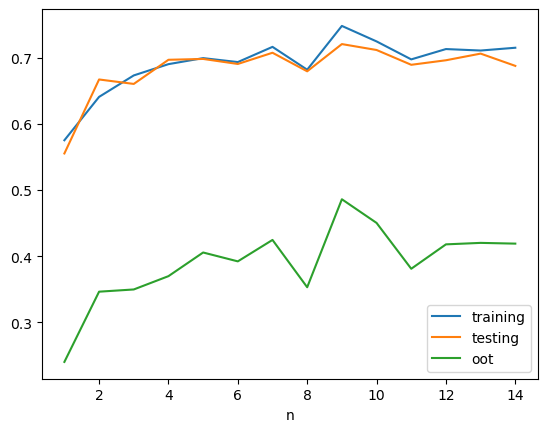

In [33]:
#complexity

training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,15,1):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = MLPClassifier(hidden_layer_sizes=(20,20,),activation='logistic',alpha= math.exp(-i),solver='adam',learning_rate='constant')
        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_NN2.pdf', format='pdf')
plt.show()


0 0.8198051948051948 0.7765151515151515 0.547486033519553
1 0.7755443886097152 0.7137809187279152 0.5418994413407822
2 0.7964458804523424 0.7777777777777778 0.553072625698324
3 0.7993579454253612 0.754863813229572 0.547486033519553
4 0.8105939004815409 0.7509727626459144 0.553072625698324
loop trn tst oot 1 0.8003494619548309 0.7547820847792661 0.5486033519553073
0 0.8103727714748784 0.7756653992395437 0.5363128491620112
1 0.8466453674121406 0.8070866141732284 0.5363128491620112
2 0.808446455505279 0.728110599078341 0.5363128491620112
3 0.8288431061806656 0.7751004016064257 0.553072625698324
4 0.8559870550161812 0.816793893129771 0.5586592178770949
loop trn tst oot 2 0.8300589511178289 0.780551381445462 0.5441340782122905
0 0.8526148969889065 0.8273092369477911 0.547486033519553
1 0.837171052631579 0.8419117647058824 0.5251396648044693
2 0.8541329011345219 0.8288973384030418 0.5586592178770949
3 0.8417721518987342 0.8669354838709677 0.547486033519553
4 0.8569105691056911 0.822641509433

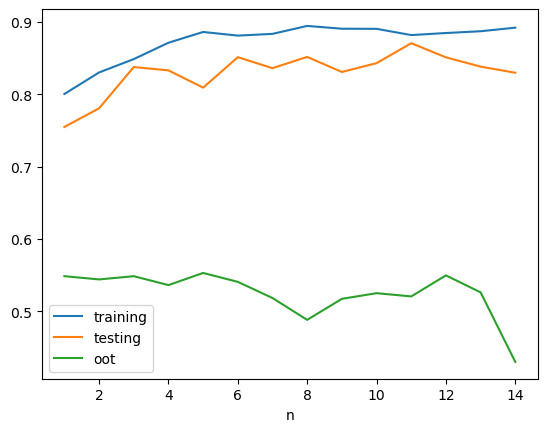

In [40]:
#complexity

training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,15,1):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = xgb.XGBClassifier(colsample_bytree = 0.8,max_depth= 50, n_estimators=5*i,learning_rate=0.3,gamma=20)
        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_xgb.pdf', format='pdf')
plt.show()


Max possible savings: 21,036,000.0


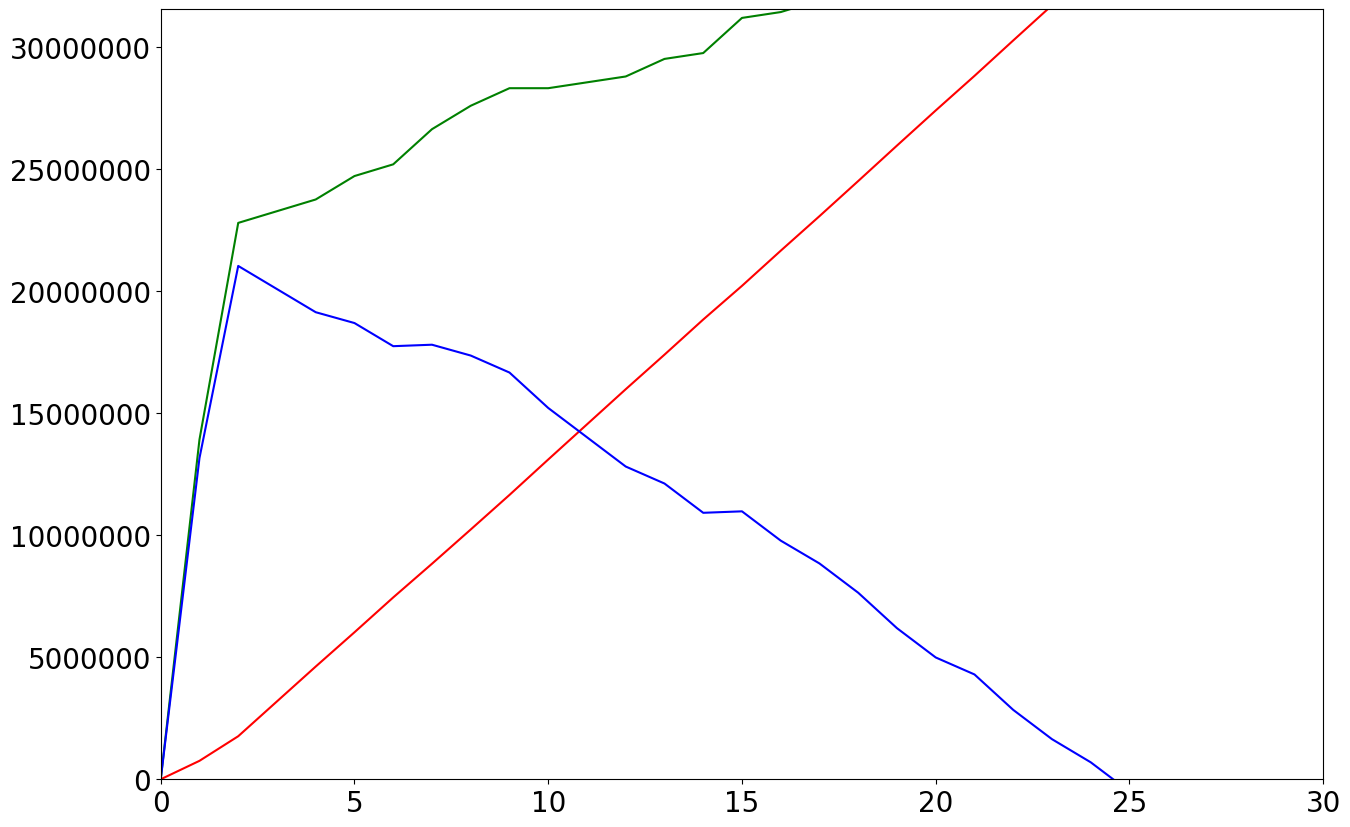

In [37]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')


In [40]:
Financials_oot['Overall Savings']

0              0.0
1       13164000.0
2       21036000.0
3       20088000.0
4       19140000.0
          ...     
96     -95256000.0
97     -96456000.0
98     -97908000.0
99     -99108000.0
100   -100056000.0
Name: Overall Savings, Length: 101, dtype: float64